<a href="https://colab.research.google.com/github/rapu34/A1_performance_factory_Aveners/blob/main/A_B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
bidding = pd.read_csv("/content/drive/MyDrive/A1project/bidding_result.csv", encoding='UTF8')

In [35]:
indexs = list(set(bidding['index'].to_list()))
print(len(indexs))

48896


In [36]:
idx_distinct_df = bidding.drop_duplicates(['index'])
idx_distinct_df

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,date
0,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,20221031
1,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20221031
2,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,20221031
3,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN,20221031
4,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN,20221031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337083,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20230103
1337084,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,20230103
1337085,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN,20230103
1337086,2566891,2,0,0.0,4.000000,500,21000,21000,3000,생활/건강,정원/원예용품,화분받침,NaN,20230103


In [37]:
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)
bidding['Sum of AD rank'] # rank 살리자 -가설: 특정 rank 구간에 click 까지만 유의미한 결과가 나타났다. 
#확인 2-4등일때 click 이 가장 많음
# 여성 상품의 경우 유의미한 순위 확인

0           3.0
1           3.0
2           8.0
3           4.0
4           6.0
           ... 
1337083    13.0
1337084    17.0
1337085     8.0
1337086     4.0
1337087    12.0
Name: Sum of AD rank, Length: 1337088, dtype: float64

In [38]:
# 날짜 데이터 테이트타임으로 바꾸기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

In [39]:
_trans_date_time(bidding)


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [40]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)

###결측치 처리

In [41]:
# null값 퍼센트로 보기
(bidding.isnull().sum()/ bidding.shape[0]).sort_values(ascending=False)

CPC                0.753309
Category Name 4    0.304360
Category Name 3    0.004388
Sum of AD rank     0.000007
index              0.000000
Impression         0.000000
Click              0.000000
Cost               0.000000
Bid                0.000000
Price(PC)          0.000000
Price(Mobile)      0.000000
Delivery Fee       0.000000
Category Name 1    0.000000
Category Name 2    0.000000
CTR                0.000000
CPM                0.000000
dtype: float64

In [42]:
"""
Category Name 3, Sum of AD rank 는 결측치 자료가 적어서 drop한다
CPC의 결측치는 우선 0 으로 처리하고 다른 EDA를 해본다

"""

bidding2 = bidding.copy()
bidding2['Category Name 4'].fillna('uncategory', inplace = True)
bidding2['CPC'].fillna(0, inplace = True)
bidding2.dropna(axis = 0, inplace = True)
print(bidding2.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현
bidding2

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [ ]:
# TIp
# 베이지안 a/b test? 왜 베이지안을 선택했는가 를 포트폴리오로  쓰기 장점 -> 
# 상황에 대한 맞춤으로 포트폴리오 스토리 만들기

In [43]:
bidding3 = bidding2.drop_duplicates(['index'])
bidding3

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [44]:
categorys1 = list(set(bidding3['Category Name 1'].to_list()))
categorys2 = list(set(bidding3['Category Name 2'].to_list()))
categorys3 = list(set(bidding3['Category Name 3'].to_list()))
categorys4 = list(set(bidding3['Category Name 4'].to_list()))

In [45]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CTR : {cate}: {df['CTR'].mean()}")
print('-' * 50)
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CPC : {cate}: {df['CPC'].mean()}")
print('-' * 50)
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CPM : {cate}: {df['CPM'].mean()}")
print('-' * 50)

CTR : 화장품/미용: 1.2639134068914868
CTR : 가구/인테리어: 1.534402497955175
CTR : 생활/건강: 1.816915281585836
CTR : 패션의류: 1.1696922649345287
CTR : 여가/생활편의: 4.306358289042499
CTR : 패션잡화: 1.7142804235347056
CTR : 식품: 0.0
CTR : 스포츠/레저: 2.473615329335076
CTR : 출산/육아: 2.3485914213997328
CTR : 디지털/가전: 1.916043896440929
--------------------------------------------------
CPC : 화장품/미용: 65.26291993796862
CPC : 가구/인테리어: 47.029295871442436
CPC : 생활/건강: 56.909235795186234
CPC : 패션의류: 92.61124449779913
CPC : 여가/생활편의: 38.62139917695473
CPC : 패션잡화: 68.05678756462889
CPC : 식품: 0.0
CPC : 스포츠/레저: 61.13637438132432
CPC : 출산/육아: 52.6338680538919
CPC : 디지털/가전: 32.55504258551301
--------------------------------------------------
CPM : 화장품/미용: 0.2642524916943521
CPM : 가구/인테리어: 0.15693206592831607
CPM : 생활/건강: 0.21437473251733288
CPM : 패션의류: 0.5751260504201681
CPM : 여가/생활편의: 0.19740740740740742
CPM : 패션잡화: 0.17357933579335794
CPM : 식품: 0.0
CPM : 스포츠/레저: 0.3193262411347518
CPM : 출산/육아: 0.2678363832077503
CPM : 디지털/가전: 0.154

In [46]:
bidding_rank = bidding2.sort_values(by = 'Sum of AD rank', ignore_index=True, ascending=True)
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [47]:
top_rank = list(set(bidding_rank['Sum of AD rank'].to_list()))
top_rank = top_rank[:20]
top_rank

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0]

In [61]:
design_A = bidding_rank[bidding_rank['Sum of AD rank'] <= 5] 
design_B = bidding_rank[bidding_rank['Sum of AD rank'] >= 5] 

In [ ]:
design_A

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518296,5361675,7,0,0.0,5.0,350,95000,95000,0,생활/건강,주방용품,프라이팬,구이팬,0.000000,0.0,0.00
518297,7290486,38,1,140.0,5.0,150,10800,10800,3000,가구/인테리어,홈데코,쿠션/방석,일반방석,2.631579,140.0,0.14
518298,4559826,12,0,0.0,5.0,350,6900,6900,3000,생활/건강,주방용품,잔/컵,와인잔,0.000000,0.0,0.00
518299,7116270,24,0,0.0,5.0,500,13000,13000,3000,가구/인테리어,홈데코,쿠션/방석,쿠션커버,0.000000,0.0,0.00


In [63]:
bidding_rank[bidding_rank["Sum of AD rank"] <= 5].groupby("Sum of AD rank")["Cost"].sum() # A
# rank가 2등일 때 cost가 제일 높게 나왔는데, 가장 많은 카테고리는 무엇일까?(help)

Sum of AD rank
1.0    26016690.0
2.0    60188780.0
3.0    43151200.0
4.0    27817050.0
5.0    20540880.0
Name: Cost, dtype: float64

In [64]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["Cost"].sum()[:10] # B

Sum of AD rank
5.0     20540880.0
6.0     15452810.0
7.0     11079680.0
8.0      8283100.0
9.0      5907580.0
10.0     4359510.0
Name: Cost, dtype: float64

In [74]:
bidding_rank[bidding_rank["Sum of AD rank"] == 2].groupby("Sum of AD rank")["Category Name 1"].value_counts()[:10]

Sum of AD rank  Category Name 1
2.0             가구/인테리어            90790
                생활/건강              33958
                출산/육아               3751
                스포츠/레저              1725
                화장품/미용               956
                디지털/가전               793
                패션잡화                 566
                패션의류                 217
                여가/생활편의              181
                식품                    11
Name: Category Name 1, dtype: int64

In [73]:
bidding_rank[bidding_rank["Sum of AD rank"] == 2].groupby("Category Name 1")["Category Name 2"].value_counts()[:10] # A

Category Name 1  Category Name 2
가구/인테리어          침실가구               17775
                 거실가구               14018
                 인테리어소품             11208
                 서재/사무용가구            9448
                 주방가구                9327
                 커튼/블라인드             5897
                 수납가구                5266
                 카페트/러그              4681
                 침구단품                4502
                 홈데코                 3093
Name: Category Name 2, dtype: int64

In [72]:
bidding_rank[bidding_rank["Sum of AD rank"] == 3].groupby("Sum of AD rank")["Category Name 1"].value_counts()[:10] # A

Sum of AD rank  Category Name 1
3.0             가구/인테리어            73140
                생활/건강              25752
                출산/육아               3004
                스포츠/레저              1291
                화장품/미용               880
                디지털/가전               561
                패션잡화                 556
                패션의류                 160
                여가/생활편의              134
                식품                    18
Name: Category Name 1, dtype: int64

In [56]:
def test(category):
    df = bidding_rank.loc[bidding_rank['Sum of AD rank'] <= 5]
    print(df.loc[bidding_rank['Category Name 1'] == category, 'CTR'].mean())

In [79]:
#Design A CTR 확인
test('가구/인테리어')
test('생활/건강')
test('출산/육아')
#category 순위에서 어떤품목이 1등일까

2.305766026852605
2.6521993850021186
3.1493984683748972


In [75]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["Cost"].sum()[:10] # B

Sum of AD rank
5.0     20540880.0
6.0     15452810.0
7.0     11079680.0
8.0      8283100.0
9.0      5907580.0
10.0     4359510.0
Name: Cost, dtype: float64

In [76]:
bidding_rank[bidding_rank["Sum of AD rank"] == 5].groupby("Sum of AD rank")["Category Name 1"].value_counts()[:10] # B
# 1~5등(A에서는 Category Name 2 침실가구가 높은 반면, 5~10등은 가구/인테리어가 높았다. )

Sum of AD rank  Category Name 1
5.0             가구/인테리어            67310
                생활/건강              22815
                출산/육아               2165
                스포츠/레저              1147
                화장품/미용               773
                패션잡화                 578
                디지털/가전               548
                패션의류                 182
                여가/생활편의               65
                식품                     8
Name: Category Name 1, dtype: int64

In [78]:
bidding_rank[bidding_rank["Sum of AD rank"] == 5].groupby("Category Name 1")["Category Name 2"].value_counts()[:10] # B

Category Name 1  Category Name 2
가구/인테리어          침실가구               14453
                 거실가구                9952
                 주방가구                8348
                 서재/사무용가구            8012
                 인테리어소품              6469
                 수납가구                4519
                 커튼/블라인드             3560
                 카페트/러그              3038
                 침구단품                2530
                 홈데코                 2218
Name: Category Name 2, dtype: int64

In [82]:
def test(category):
    df = bidding_rank.loc[bidding_rank['Sum of AD rank'] >= 5][:10]
    print(df.loc[bidding_rank['Category Name 1'] == category, 'CTR'].mean())

In [83]:
#Design B CTR 확인
test('가구/인테리어')
test('생활/건강')
test('출산/육아')

#1~5등에 비해 현저하게 CTR이 낮음

0.0
0.3024803387779795
1.550387596899225


In [ ]:
from scipy import stats


In [ ]:
#design_A = design_A.drop(columns=['index','CPC','Cost','Bid','Price(PC)','Price(Mobile)','Delivery Fee','Category Name 1','Category Name 2','Category Name 3','Category Name 4','Impression'])
rank_A = design_A['Sum of AD rank']
rank_A

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
518296    5.0
518297    5.0
518298    5.0
518299    5.0
518300    5.0
Name: Sum of AD rank, Length: 518301, dtype: float64

In [ ]:
rank_A.sum()

1581628.0

In [ ]:
Click_A= design_A['Click']
Click_A

0         1
1         0
2         0
3         0
4         0
         ..
518296    0
518297    1
518298    0
518299    0
518300    0
Name: Click, Length: 518301, dtype: int64

In [ ]:
Click_A.sum()

736046

In [ ]:
#design_B = design_B.drop(columns=['index','CPC','Cost','Bid','Price(PC)','Price(Mobile)','Delivery Fee','Category Name 1','Category Name 2','Category Name 3','Category Name 4'])
rank_B= design_B['Sum of AD rank']
rank_B.sum()

14066088.0

In [ ]:
Click_B= design_B['Click']
Click_B

422710     5
422711     0
422712     0
422713     0
422714     0
          ..
1331206    0
1331207    0
1331208    0
1331209    0
1331210    0
Name: Click, Length: 908501, dtype: int64

In [ ]:
Click_B.sum()

300938

In [ ]:
print(rank_A.sum(), Click_A.sum())
print(rank_B.sum(), Click_B.sum())

1581628.0 736046
14066088.0 300938


In [ ]:
stats.ttest_ind(design_A,
                design_B,
                equal_var=False)
# https://data101.oopy.io/ab-test-python-or-without-code

Ttest_indResult(statistic=146.38509721852012, pvalue=0.0)

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from scipy import stats as st 
import numpy as np

visit_A = rank_A.sum()
visit_B = rank_B.sum()

conversion_A = Click_A.sum()
conversion_B = Click_B.sum()

alpha = 1
beta  = 1
n_samples = 1000
print(alpha)

posterior_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A)
posterior_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B)
posterior_samples_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A).rvs(n_samples)
posterior_samples_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B).rvs(n_samples)

# posterior mean 
print((posterior_samples_A > posterior_samples_B).mean())

1
1.0


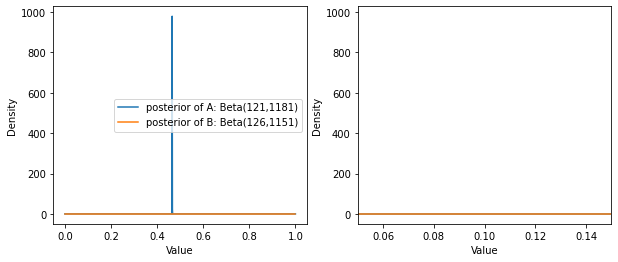

In [ ]:
# Posterior Dist of A and B
fig,axes = plt.subplots(1,2,figsize=(10,4))
x = np.linspace(0,1,1000)
i=0
for ax in axes:
    ax.plot(x, posterior_A.pdf(x), label = "posterior of A: Beta(121,1181)")
    ax.plot(x, posterior_B.pdf(x), label = "posterior of B: Beta(126,1151)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    if i==1:
        ax.set_xlim(0.05, 0.15)
    i+=1
axes[0].legend()

In [ ]:
purchase_counts = df.groupby(['group', 'is_purchase']).user_id.count().reset_index()


In [ ]:
Cost_A= design_A['Cost']
Cost_A.sum()
print(rank_A.sum())

1581628.0


In [ ]:
Cost_B= design_B['Cost']
Cost_B.sum()

83448890.0

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from scipy import stats as st 
import numpy as np

visit_A = rank_A.sum()
visit_B = rank_B.sum()

conversion_A = Cost_A.sum()
conversion_B = Cost_B.sum()

alpha = 1
beta  = 1
n_samples = 1000
print(alpha)

posterior_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A)
posterior_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B)
posterior_samples_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A).rvs(n_samples)
posterior_samples_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B).rvs(n_samples)

# posterior mean 
print((posterior_samples_A > posterior_samples_B).mean())

1


ValueError: ignored